# Introduction
* The original dataset contains 2D images that represents transverse slices from MRIs. The transverse anatomical plane offers better visibility for the annotation work as the image resolution is at its highest. While it is possible to put all slices together to build a 3D image and train 3D-conv models from them, the number of MRIs available in this competition surely is too low to train such complex model.
* This notebook has for purpose to generate a new dataset that will rebuild the 3D images from the slices, before creating slices and their groundtruths from different viewpoints. This allows to significantly augment the dataset without dramatically increasing the inputs' complexity for our models. Using this process, it is roughly possible to triple the original's dataset size by looking at the data from two other anatomical planes, which are explained [here](https://en.wikipedia.org/wiki/Anatomical_plane).

If you find this notebook helpful, please give it an upvote, as well as the corresponding dataset. It is always greatly appreciated!

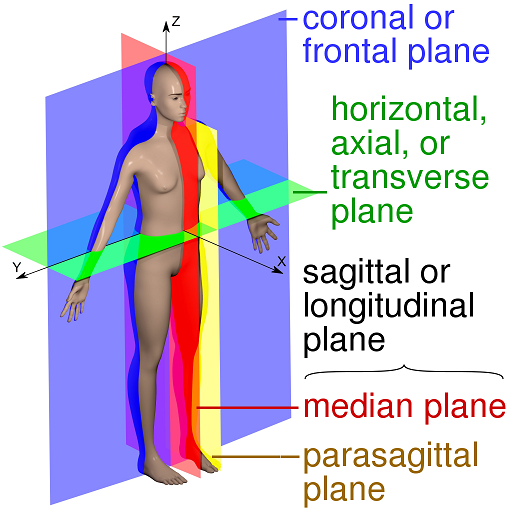

# Preparing the data

In [ ]:
import numpy as np
import pandas as pd
import os
import cv2 as cv
from PIL import Image
from tqdm import tqdm
import glob
import matplotlib.pyplot as plt
import shutil

We will start by loading the data and populate new columns which will later help to manipulate the data.

In [ ]:
train_folder = "../input/uw-madison-gi-tract-image-segmentation/train"
image_output_folder = "./images"
os.mkdir(image_output_folder)

train_df = pd.read_csv("../input/uw-madison-gi-tract-image-segmentation/train.csv")
train_df = train_df.rename(columns={"class":"organ_class"}) #class is a Python keyword
train_df["case_id"] = [int(image_id.split("_")[0].replace("case","")) for image_id in train_df["id"]]
train_df["day"] = [image_id.split("_")[1] for image_id in train_df["id"]]
train_df["slice_number"] = [int(image_id.split("_")[-1]) for image_id in train_df["id"]]
train_df["image_id"] = [image_id.rsplit('_',1)[0] for image_id in  train_df["id"]]
train_df["slice_plane"] = "transverse"
train_df.head()

Next, we need to spend a couple of minutes retrieving the scans' width and height. It will be useful later as the size can vary.

In [ ]:
width_list = []
height_list = []
for idx, row in tqdm(train_df.iterrows()):
    filepath = "{}/case{}/case{}_{}/scans/".format(train_folder, row.case_id, row.case_id, row.day)
    filename = [x for x in os.listdir(filepath) if int(x.split("_")[1])==row.slice_number][0]
    width = int(filename.split("_")[2])
    height = int(filename.split("_")[3])
    width_list.append(width)
    height_list.append(height)
    
train_df["width"] = width_list
train_df["height"] = height_list

In [ ]:
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return ' '.join([str(x) for x in run_lengths])

def decode_rle(rle, height, width):
    s = rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(height*width, dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape((height, width))

# Creating new viewpoints and groundtruths

In [ ]:
def build_3D_img(folder_path):
    '''
    Take all slices and store them into a 3D numpy array
    '''
    slice_list = sorted(os.listdir(folder_path))
    slice_pixel_list = []
    for slice_filename in slice_list:
        pixel_slice = Image.open(folder_path+slice_filename)
        slice_pixel_list.append(np.array(pixel_slice))
        pixel_slice.close()
    return np.array(slice_pixel_list)

def build_3D_segmentation(segmentation_df, img_width, img_height):
    '''
    Take all segmentation slices, decode the RLE and 
    concatenate the slices together to obtain a 3D numpy array
    '''
    slice_pixel_list = []
    for segmentation in segmentation_df["segmentation"].values:
        if pd.isnull(segmentation):
            slice_pixel_list.append(np.zeros((img_height,img_width)).astype("float64"))
        else:
            slice_pixel_list.append(decode_rle(segmentation, img_height, img_width))
    return np.array(slice_pixel_list)

In [ ]:
def generate_sagittal_slices(df, case_id, day, MRI_3D_img, 
                             large_bowel_3D_mask, small_bowel_3D_mask, stomach_3D_mask):
    '''
    Create slices for an MRI from a sagittal plane and
    returns a dataframe with filepaths and groundtruths
    '''
    
    slice_info_list = []
    for i in range(MRI_3D_img.shape[2]):
        filename = "case{}_{}_sagittal_{}.png".format(case_id, day, i)
        sagittal_slice = Image.fromarray(MRI_3D_img[:,:,i])
        width, height = sagittal_slice.size
        
        sagittal_slice.save("{}/{}".format(image_output_folder,filename))
        large_bowel_rle = rle_encoding(large_bowel_3D_mask[:,:,i].T)
        small_bowel_rle = rle_encoding(small_bowel_3D_mask[:,:,i].T)
        stomach_rle = rle_encoding(stomach_3D_mask[:,:,i].T)

        slice_info_list.append({"filename":filename, 
                        "organ_class":"large_bowel", 
                        "segmentation":large_bowel_rle, 
                        "slice_plane":"sagittal",
                        "width":width,
                        "height":height})
        slice_info_list.append({"filename":filename, 
                        "organ_class":"small_bowel", 
                        "segmentation":small_bowel_rle, 
                        "slice_plane":"sagittal",
                        "width":width,
                        "height":height})
        slice_info_list.append({"filename":filename, 
                        "organ_class":"stomach", 
                        "segmentation":stomach_rle, 
                        "slice_plane":"sagittal",
                        "width":width,
                        "height":height})
    return df.append(slice_info_list)

def generate_coronal_slices(df, case_id, day, MRI_3D_img, 
                            large_bowel_3D_mask, small_bowel_3D_mask, stomach_3D_mask):
    '''
    Create slices for an MRI from a coronal plane and
    returns a dataframe with filepaths and groundtruths
    '''
    
    slice_info_list = []
    for i in range(MRI_3D_img.shape[1]):
        filename = "case{}_{}_coronal_{}.png".format(case_id, day, i)
        coronal_slice = Image.fromarray(MRI_3D_img[:,i,:])
        width, height = coronal_slice.size
        
        coronal_slice.save("{}/{}".format(image_output_folder,filename))
        large_bowel_rle = rle_encoding(large_bowel_3D_mask[:,i,:].T)
        small_bowel_rle = rle_encoding(small_bowel_3D_mask[:,i,:].T)
        stomach_rle = rle_encoding(stomach_3D_mask[:,i,:].T)
        
        slice_info_list.append({"filename":filename, 
                        "organ_class":"large_bowel", 
                        "segmentation":large_bowel_rle, 
                        "slice_plane":"coronal",
                        "width":width,
                        "height":height})
        slice_info_list.append({"filename":filename, 
                        "organ_class":"small_bowel", 
                        "segmentation":small_bowel_rle, 
                        "slice_plane":"coronal",
                        "width":width,
                        "height":height})
        slice_info_list.append({"filename":filename, 
                        "organ_class":"stomach", 
                        "segmentation":stomach_rle, 
                        "slice_plane":"coronal",
                        "width":width,
                        "height":height})
    return df.append(slice_info_list)

In [ ]:
def create_3D_img_and_seg(df, new_dataset_df, img_id, img_width, img_height):
    '''
    concatenate MRI slices and their segmentation information
    '''

    img_info_df = df[df.id.str.contains(img_id)]
    case_id = img_info_df.iloc[0].case_id
    day = img_info_df.iloc[0].day
    segmentation_large_bowel_df = img_info_df.query("organ_class=='large_bowel'")
    segmentation_small_bowel_df = img_info_df.query("organ_class=='small_bowel'")
    segmentation_stomach_df = img_info_df.query("organ_class=='stomach'")
    
    MRI_3D_img = build_3D_img("{}/case{}/case{}_{}/scans/".format(train_folder, case_id, case_id, day))
    large_bowel_3D_mask = build_3D_segmentation(segmentation_large_bowel_df, img_width, img_height)
    small_bowel_3D_mask = build_3D_segmentation(segmentation_small_bowel_df, img_width, img_height)
    stomach_3D_mask = build_3D_segmentation(segmentation_stomach_df, img_width, img_height)
    
    new_dataset_df = generate_sagittal_slices(new_dataset_df, case_id, day, MRI_3D_img, 
                                             large_bowel_3D_mask, small_bowel_3D_mask, stomach_3D_mask)
    new_dataset_df = generate_coronal_slices(new_dataset_df, case_id, day, MRI_3D_img, 
                                             large_bowel_3D_mask, small_bowel_3D_mask, stomach_3D_mask)
    return new_dataset_df

Let's generate these new images from the 2 different anatomical planes!

In [ ]:
new_dataset_df = pd.DataFrame()
for img_id in tqdm(train_df.image_id.unique()):
    id_df = train_df.query("image_id==@img_id").iloc[0]
    img_width = id_df.width
    img_height = id_df.height
    new_dataset_df = create_3D_img_and_seg(train_df, new_dataset_df, img_id, img_width, img_height)

In [ ]:
new_dataset_df[new_dataset_df.filename.str.contains("case123_day20")].query("segmentation!=''")

In [ ]:
new_dataset_df["segmentation"] = [np.nan if segmentation=="" else segmentation for segmentation in new_dataset_df["segmentation"]]

# Adding the original data

In order to ensure that it is easy to use this dataset, we will also copy and merge the data from the original dataset.

In [ ]:
train_df.head()

In [ ]:
slice_info_list = []

for idx,row in tqdm(train_df.iterrows()):
    case_id = row.case_id
    day = row.day
    slice_number = int(row.slice_number)
    img_width = row.width
    img_height = row.height
    
    scan_folder_path = "{}/case{}/case{}_{}/scans".format(train_folder, case_id, case_id, day)
    slice_file_list = os.listdir(scan_folder_path)
    selected_slice_filename = [x for x in slice_file_list if int(x.split("_")[1])==slice_number][0]
    new_filename = "case{}_{}_transverse_{}.png".format(case_id,day,slice_number)
    if row.organ_class=="large_bowel":
        shutil.copy("{}/{}".format(scan_folder_path,selected_slice_filename), 
                    "{}/{}".format(image_output_folder,new_filename))
    
        slice_info_list.append({"filename":new_filename, 
                        "organ_class":row.organ_class, 
                        "segmentation":row.segmentation, 
                        "slice_plane":"transverse",
                        "width":img_width,
                        "height":img_height})
    elif row.organ_class=="small_bowel":
        slice_info_list.append({"filename":new_filename, 
                        "organ_class":row.organ_class, 
                        "segmentation":row.segmentation, 
                        "slice_plane":"transverse",
                        "width":img_width,
                        "height":img_height})
    elif row.organ_class=="stomach":
        slice_info_list.append({"filename":new_filename, 
                        "organ_class":row.organ_class,  
                        "segmentation":row.segmentation, 
                        "slice_plane":"transverse",
                        "width":img_width,
                        "height":img_height})
    
new_dataset_df = new_dataset_df.append(slice_info_list)

In [ ]:
new_dataset_df.to_csv("train.csv",index=False)

As I noticed that having a large number of files in the "working" directory seemed to slow the notebook down on Kaggle, the next line removed all files. If you wish to regenerate the dataset, make sure to comment out this line!

In [ ]:
!rm -rf ./*

# How to use the dataset

While the previous part of this notebook generated the dataset and all the outputs were stored in the notebook's "working" directory. A public dataset has already been created and is available for you to quickly start working with it. The following cells will show you how to browse through the dataset.

In [ ]:
dataset_folder_path = "../input/uwmgit-all-anatomical-planes/"
dataset_image_path = "../input/uwmgit-all-anatomical-planes/images/"
df = pd.read_csv(dataset_folder_path+"train.csv")
df.head()

In [ ]:
def display_slice(df, filename, organ_class):
    '''
    Open the image and apply the RLE segmentation onto it and display them all
    '''
    slice_df = df.query("filename==@filename and organ_class==@organ_class").iloc[0]
    if pd.isnull(slice_df.segmentation):
        print("segmentation is null")
    else:
        seg_img = decode_rle(slice_df.segmentation, slice_df.height, slice_df.width)
        img = np.array(Image.open(dataset_image_path+filename)).astype("float64")
        img /= np.max(img)
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        plt.rcParams["figure.figsize"] = (25,10)
        ax1.imshow(img)
        ax2.imshow(seg_img)
        ax3.imshow(img+(seg_img))
        plt.show()

In [ ]:
case = 113
day = 12
slice_number = 142
organ_class = "small_bowel"
anatomical_plane = "sagittal"
filename = "case{}_day{}_{}_{}.png".format(case, day, anatomical_plane, slice_number)
display_slice(df, filename, organ_class)

In [ ]:
case = 113
day = 12
slice_number = 142
organ_class = "large_bowel"
anatomical_plane = "sagittal"
filename = "case{}_day{}_{}_{}.png".format(case, day, anatomical_plane, slice_number)
display_slice(df, filename, organ_class)

In [ ]:
case = 42
day = 19
slice_number = 180
organ_class = "large_bowel"
anatomical_plane = "sagittal"
filename = "case{}_day{}_{}_{}.png".format(case, day, anatomical_plane, slice_number)
display_slice(df, filename, organ_class)

In [ ]:
case = 134
day = 22
slice_number = 120
organ_class = "stomach"
anatomical_plane = "coronal"
filename = "case{}_day{}_{}_{}.png".format(case, day, anatomical_plane, slice_number)
display_slice(df, filename, organ_class)

In [ ]:
case = 16
day = 0
slice_number = 120
organ_class = "large_bowel"
anatomical_plane = "coronal"
filename = "case{}_day{}_{}_{}.png".format(case, day, anatomical_plane, slice_number)
display_slice(df, filename, organ_class)

In [ ]:
case = 30
day = 0
slice_number = 122
organ_class = "small_bowel"
anatomical_plane = "transverse"
filename = "case{}_day{}_{}_{}.png".format(case, day, anatomical_plane, slice_number)
display_slice(df, filename, organ_class)

In [ ]:
case = 129
day = 22
slice_number = 60
organ_class = "stomach"
anatomical_plane = "transverse"
filename = "case{}_day{}_{}_{}.png".format(case, day, anatomical_plane, slice_number)
display_slice(df, filename, organ_class)

In [ ]:
case = 129
day = 27
slice_number = 60
organ_class = "stomach"
anatomical_plane = "transverse"
filename = "case{}_day{}_{}_{}.png".format(case, day, anatomical_plane, slice_number)
display_slice(df, filename, organ_class)

### Thanks for reading this notebook! If you found this notebook helpful, please give it an upvote, as well as the corresponding dataset. It is always greatly appreciated!